# Modelo de Trading Algorítmico

### 1. Preparación de los datos
> ###### 1.1. Importar los datos
> ###### 1.2. Generación de características


### 2. Modelando la estrategia
> ###### 2.1. Encontrar los mejores activos
> ###### 2.2. Combinar los algorítmos	
> ###### 2.3. Aplicar técnicas de gestión de carteras

### 3. Encontrar el take profit, stop loss y apalancamientos óptimos
> ###### 3.1. Take profit óptimo	
> ###### 3.2. Stop loss óptimo
> ###### 3.3. Apalancamiento óptimo


In [95]:
import numpy as np
import pandas as pd
import MetaTrader5 as mt5
import time
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
mt5.initialize()
import ta

## 1. Preparación de los datos

### 1.1. Importar los datos

Obtenemos del broker todos los activos que nos ofrece para operar, su sector y su descripción.
Tomaremos solo activos que tengan una baja dispersión entre precio bid/ask.


In [96]:
# Inicializamos la aplicación del broker instalada en nuestro PC.
mt5.initialize()

# Creamos listas vacias
symbols = []
sectors = []
descriptions = []

# Obtenemos del broker la información para todos los símbolos  (activos)
symbols_information = mt5.symbols_get()

# El broker nos devuelve una tupla, la pasamos a lista
symbols_information_list = list(symbols_information)

# Extraemos los nombres de los símbolos
for element in symbols_information_list:
    symbols.append(list(element)[-3])
    sectors.append(list(element)[-1].split("\\")[0])
    descriptions.append(list(element)[-7])
    
# Creamos un dataframe
informations = pd.DataFrame([symbols, sectors, descriptions], index=["Symbol", "Sector", "Description"]).transpose()


# Creamos una lista vacia
spread = []

# Calculamos el spread de cada activo
for symbol in informations["Symbol"]:
    try:
        ask =  mt5.symbol_info_tick(symbol).ask
        bid =  mt5.symbol_info_tick(symbol).bid
        spread.append((ask - bid) / bid )
        
    except:
        spread.append(None)

# Tomamos los activos con spread < 0.07%
informations["Spread"] = spread
informations = informations.dropna()
lowest_spread_asset = informations.loc[informations["Spread"]<0.0007]

In [97]:
informations

,Symbol,Sector,Description,Spread
0,AUDCAD,Forex,Australian Dollar vs Canadian Dollar,0.000099
1,AUDCHF,Forex,Australian Dollar vs Swiss Franc,0.000199
2,AUDJPY,Forex,Australian Dollar vs Japanese Yen,0.000131
3,AUDNZD,Forex,Australian Dollar vs New Zealand Dollar,0.000168
4,AUDUSD,Forex,Australian Dollar vs US Dollar,0.000074
...,...,...,...,...
784,YUM,Stocks,Yum! Brands Inc,0.001172
785,ZBH,Stocks,Zimmer Biomet Holdings Inc,0.002695
786,ZTS,Stocks,Zoetis Inc,0.001299
787,EURSEK,Forex,Euro vs Swedish krona,0.000879


Función para obtener los datos desde la API el broker:

In [98]:
def get_data(symbol, n, timeframe=mt5.TIMEFRAME_D1):
    """ Function which returns the data of the symbol"""

    # Inicializamos la aplicación
    mt5.initialize()
    
    # Pasamos los datos a un DataFrame
    utc_from = datetime.now()+timedelta(hours=2)
    rates = mt5.copy_rates_from(symbol, timeframe, utc_from,n) 
    rates_frame = pd.DataFrame(rates)
    
    # Convertimos tiempo en segundos a formato datatime 
    rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
    rates_frame['time'] =  pd.to_datetime(rates_frame['time'], format='%Y-%m-%d')
    rates_frame = rates_frame.set_index('time')
    
    return rates_frame

### 1.2. Generación de características. 

Es importante destacar que desplazamos las características una posición hacia adelante en el dataframe para evitar data leakeage. Asi hacemos las prediciones con las características del dia anterior. Por ejemplo, si estamos prediciendo el día 15 del dataframe tendremos que tomar las características del día 14, de lo contrario estaremos prediciendo el pasado con el futuro.

In [99]:
def features_engineering(df):
    """ Esta función crea todos los conjuntos necesarios para el algorítmo"""

    # Para llamar las funciones desde fuera de la función
    global X_train
    global X_test
    global y_train_reg
    global y_train_cla 
    global X_train_scaled 
    global X_test_scaled
    global split_train_test
    global split_test_valid
    global X_valid
    global X_valid_scaled
    global X_train_pca
    global X_test_pca
    global X_val_pca


    # Métricas para calcular el retorno de la estrategia
    df["returns"] = ((df["close"] - df["close"].shift(1)) / df["close"])
    df["sLow"] = ((df["low"] - df["close"].shift(1)) / df["close"].shift(1))
    df["sHigh"] = ((df["high"] - df["close"].shift(1)) / df["close"].shift(1))

    # Ingeniería de características
    df["returns t-1"] = df[["returns"]].shift(1)

    # media de los retornos en diferentes intervalos
    df["mean returns 15"] = df[["returns"]].rolling(15).mean().shift(1)
    df["mean returns 60"] = df[["returns"]].rolling(60).mean().shift(1)

    # Volatilidad de los retornos
    df["volatility returns 15"] = df[["returns"]].rolling(15).std().shift(1)
    df["volatility returns 60"] = df[["returns"]].rolling(60).std().shift(1)

    # Quitamos missing values
    df = df.dropna()
    
    # tamaño del conjunto deentrenamiento
    split = int(0.80*len(df))
   

   
    list_x = ["returns t-1", "mean returns 15", "mean returns 60",
                  "volatility returns 15",
                  "volatility returns 60"]


    split_train_test = int(0.70*len(df))
    split_test_valid = int(0.90*len(df))

    # Creamos el conjunto de entrenamiento
    X_train = df[list_x].iloc[:split_train_test]

    y_train_reg = df[["returns"]].iloc[:split_train_test]
    
    # Target: clasificacion binaria, 0 predice bajada y 1 predice subida al dia siguiente
    y_train_cla = np.round(df[["returns"]].iloc[:split_train_test]+0.5)


    # Creamos el conjunto de test
    X_test = df[list_x].iloc[split_train_test:split_test_valid]
    
    # Creamos el conjunto de validación
    X_val = df[list_x].iloc[split_test_valid:]


    # NORMALIZACIÓN 
    # Importamos la clase
    from sklearn.preprocessing import StandardScaler

    # Inicializamosla clase
    sc = StandardScaler()

    # Estandarizamos los datos
    X_train_scaled = sc.fit_transform(X_train)
    X_test_scaled = sc.transform(X_test)
    X_val_scaled = sc.transform(X_val)
    
    
    
    
    
    # PCA
    # Importamos la clase
    from sklearn.decomposition import PCA
    
    # Inicializamosla clase
    pca = PCA(n_components=3)
    
    # Aplicamos la PCA
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    

## 2. Modelando la estrategia

### 2.1. Encontrar los mejores activos.

La métrica que usaremos para seleccionar los activos es el Ratio de Sharpe. El ratio de Sharpe permite entender los beneficios adicionales al asumir un 1% más de riesgo. Una inversión con Sharpe > 1 es una inversión muy buena pues tenemos un rentabilidad esperada positiva, pero con un riesgo asumido menor que el rendimiento.  
  
  
Hemos tomado esta decisión porque quizás el error cuadrático medio o el accuracy no sea suficiente para entrenar bien el modelo, ya que puede predecir bien si bajará o subirá el activo al día siguiente pero no con qué intensidad lo hará. Asi que puede que seleccionemos activos donde el beneficio al día siguiente sea muy bajo por lo que no compemsa asumir el riesgo de invertir. 
  
  
Por otro lado, con el Ratio de Sharpe seleccionaremos aquellos activos donde el ratio beneficio / riesgo es el mayor posible.  

Puntualizar, en linea con lo anteriormente dicho, que el objetivo principal del modelo que estamos construyendo no es solo generar el mayor beneficio posible, si no preservar nuestro capital en el tiempo y secundariamente generar beneficios. Para ello aplicaremos técnicas de gestión de carteras y riesgos.

In [100]:
def predictor(df, model, reg=True, spread = 0.035):
    model.fit(X_train_pca, y_train_cla)


    df = df.dropna()
    # Crea la predición para el dataset
    df["prediction"] = model.predict(np.concatenate((X_train_pca,X_test_pca, X_val_pca),
                                        axis=0))

    if reg==False:
        df["prediction"] = np.where(df["prediction"]==0, -1, 1)

    df["prediction"] = df.prediction
    df=df.dropna()
    # Calcula el retorno de la estrategia
    df["strategy"] = df["prediction"]* df["returns"]

    returns = df["strategy"].iloc[split_train_test:split_test_valid]

    return np.sqrt(252) * (returns.mean()-(spread/100))/ returns.std()

#### Automatización del testing.

Calculamos las estrategias de trading (modelos de predicción) para todos los activos que nos ofrece el broker con spread inferior a 0.0007 (534 activos) para posteriormete analizar que activos nos conviene seleccionar.  
El estadistico que utilizaremos para seleccionar el mejor activo / estrategia es el ratio de Sharpe. Es un ratio que calcula la rentabilidad ajustada según su riesgo. Cuanto mayor sea el ratio de Sharpe mejor. Normalmente se considera que un buen ratio de Sharpe está por encima de 1, porque ofrece más rentabilidad por unidad de volatilidad.  
En el siguiente código pasamos todos los activos por 3 modelos difrentes y calculamos el ratio de Sharpe de cada uno de ellos con cada modelo.


In [101]:
# Import los modelos
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from tqdm import tqdm
# Modelos
tree = DecisionTreeClassifier(max_depth=6)
svr = SVC(C=1.5)
lin = LogisticRegression()


symbols = lowest_spread_asset["Symbol"]
#symbols = lowest_spread_asset[:150]
lists = []
lenght = []
mt5.initialize()
for symbol in tqdm(symbols):
    
    try:
        df = get_data(symbol, 3500)
        df.dropna()
        df["returns"] = (df["close"] - df["close"].shift(1)) / df["close"].shift(1)


        features_engineering(df)

        
        # Decision tree rgressor
        sharpe_tree = predictor(df, tree, reg=True)    
        lists.append([symbol, "Tree", sharpe_tree, len(df)])
        
        # SVR 
        sharpe_svr = predictor(df, svr, reg=False)    
        lists.append([symbol, "SVR", sharpe_svr, len(df)])

        # Linear Regression
        sharpe_linreg = predictor(df, lin, reg=False)    
        lists.append([symbol, "LinReg", sharpe_linreg, len(df)])
        
    except:
        print("Error al importar los datos")



100%|██████████| 192/192 [09:58<00:00,  3.12s/it]


A continuación tenemos el ratio de Sharpe para cada estrategia/activo, tomaremos los 5 mejores activos y le aplicaremos el método Voting. Es decir, la estrategia final de comprar o vender será una votacion de 3 estrategias diferentes para un mismo activo.

In [102]:
results = pd.DataFrame(lists, columns=["Symbol", "Model", "Sharpe", "Lenght"])
results.sort_values(by="Sharpe", ascending=False).loc[results["Lenght"]>600].head(35)

,Symbol,Model,Sharpe,Lenght
458,MSFT,LinReg,1.670384,3500
362,NFLX,LinReg,1.352712,3500
388,PHM,SVR,1.209733,3171
139,BX,SVR,1.205258,3171
487,SCHW,SVR,1.177139,3500
456,MSFT,Tree,1.176542,3500
79,ABBV,SVR,1.103973,2605
326,MCK,LinReg,1.064065,3500
274,JCI,SVR,1.029564,3500
468,UNH,Tree,1.010943,3500


### 2.2. Combinamos los algoritmos para los 5 mejores activos.

In [195]:
["MSFT", "NFLX", "PHM", "BX", "SCHW"]

['MSFT', 'NFLX', 'PHM', 'BX', 'SCHW']

La idea detrás de VotingClassifier es combinar diferentes algorítmos clasificadores de machine learning y usar el voto de la mayoría (la moda de las labels predichas) como resultadofinal de la predicción.

In [110]:
def voting(df, reg=True):    
    """ Crea una estrategia utilizando el método voting"""

    if reg:
        tree = DecisionTreeRegressor(max_depth=6)
        svr = SVR(epsilon=1.5)
        lin = LinearRegression()
        vot = VotingRegressor(estimators=[
            ('lr', lin), ("tree", tree), ("svr", svr)])
    else:
        tree = DecisionTreeClassifier(max_depth=6)
        svr = SVC()
        lin = LogisticRegression()

        vot = VotingClassifier(estimators=[
            ('lr', lin), ("tree", tree), ("svr", svr)])

    # Entrenamos le modelo
    if reg==False:
        vot.fit(X_train_pca, y_train_cla)
    else:
        vot.fit(X_train_pca, y_train_reg)

    # Quitamos missing values 
    df = df.dropna()
    
    # Creamos las predicciones
    df["prediction"] = vot.predict(np.concatenate((X_train_pca,
                                                   X_test_pca,
                                                   X_val_pca),
                                        axis=0))
    
    # Quitamos missing values 
    df = df.dropna()
    
    if reg==False:
        df["prediction"] = np.where(df["prediction"]==0, -1, 1)

    # Calculamos la estrategia
    df["strategy"] = np.sign(df["prediction"]) * df["returns"]
    df["low_strategy"] = np.where(df["prediction"]>0, df["sLow"], -df["sHigh"])
    df["high_strategy"] = np.where(df["prediction"]>0, df["sHigh"], -df["sLow"])


    return vot, df["strategy"], df["low_strategy"], df["high_strategy"]

Calculamos las estrategias de voting para los activos seleccionados y guardamos los modelos. Posteriormente utilizaremos los modelos para obtener las señales de compra o venta con los datos que le pasemos en tiempo real desde la API del broker. Las señales de predicción que generen los modelos las enviaremos de nuevo a la API del broker para que ejecute en el mercado las ordenes de compra o venta.

In [171]:
mt5.initialize()

# Import the class
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.ensemble import VotingRegressor, VotingClassifier
import pickle
from joblib import dump, load

# Inicializamos variables
lists = []
res = pd.DataFrame()
low_assets = pd.DataFrame()
high_assets = pd.DataFrame()

for symbol in ["MSFT", "NFLX", "PHM", "BX", "SCHW"]:
    print(symbol)
    
    
    # Importamos los datos
    df = get_data(symbol, 3500)
    df = df.dropna()
    # Creamos las métricas para calcular los retornos
    df["returns"] = ((df["close"] - df["close"].shift(1)) / df["close"])
    df["sLow"] = ((df["low"] - df["close"].shift(1)) / df["close"].shift(1))
    df["sHigh"] = ((df["high"] - df["close"].shift(1)) / df["close"].shift(1))
    # Quitamos missing values
    df = df.dropna()
    
    # Creamos los sets
    features_engineering(df)

    # Ejecutamos la estretegia
    vot, res[symbol],low_assets[symbol],high_assets[symbol] = voting(df, reg=False)

    # Guardamos el modelo
    s = pickle.dumps(vot)
    alg = pickle.loads(s)

    dump(alg ,f"Models/{symbol}_voting.joblib")

MSFT
NFLX
PHM
BX
SCHW


In [241]:
split_train = int(3438*0.7)

<Axes: xlabel='time'>

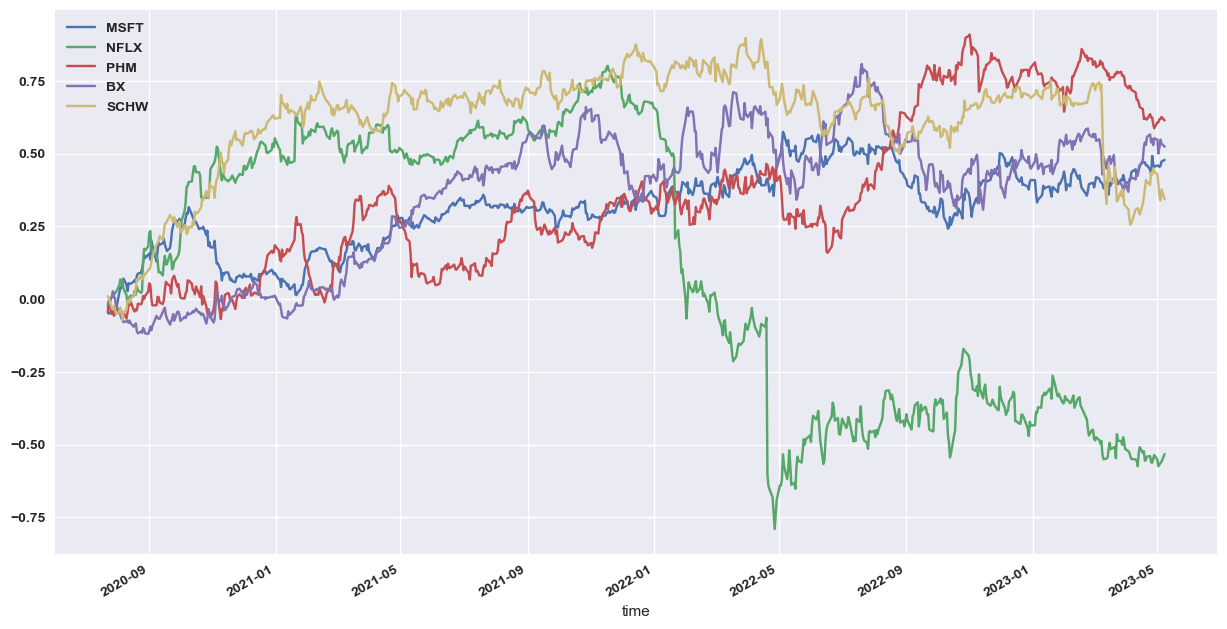

In [252]:
# mostramos el retorno acumulado de las estrategias en test set
#data = res.dropna().loc["2022-05":"2023-05"] 
data = res.dropna().iloc[split_train:]
data.cumsum().plot(figsize=(15,8))

En el gráfico anterior podemos observar como los activos tienen en test comportamientos muy diferentes y erráticos, si solo decidieramos escoger un solo activo para invertir correríamos un gran riesgo pues no podemos saber con seguridad estudiando el pasado como se va a comportar el activo en el futuro. Por ello en el siguiente apartado hablaremos de la gestión de carteras y cómo diversificar la inversión entra varios activos reduce el riesgo qque asumimos.

### 2.3. Aplicar tecnica de gestión de carteras

Aplicamos la función de criterio media-varianza para optimizar los pesos que cada activo debe de tener en la cartera para maximizar la función de utilidad de la cartera. Se aplica sobre los datos de entrenamiento y se validan los resultados con los datos de test aplicando los pesos obtenidos en el cálculo con los datos de entrenamiento. Como restricción tiene que el peso total debe de ser igual a uno. El significado de este algoritmo es que nos maximizará el beneficio ajustando el peso de cada activo en la cartera.  
  
  Como resultado la cartera estará compuesta por:
  - MSFT con un peso de 14.20 %
  - NFLX con unn peso de 4 %
  - PHM con un peso de 53.70 %
  - BX  con un peso de 28.10 %
  - SCHW con un peso de 0 %
  
  Observamos como al diversificar entre varios activos(4 en este caso) el comportamiento de la linea de rendimientos es menos errática y sigue una tendencia más suave. Al diversificar reducimos el riesgo potencial de elegir un solo activo que se comporte muy mal en el futuro.

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.25072182996275555
            Iterations: 7
            Function evaluations: 42
            Gradient evaluations: 7
[0.142 0.04  0.537 0.281 0.   ]
[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.26 	 Alpha: 16.12 %	     Sharpe: 0.79 	 Sortino: 0.068
  -----------------------------------------------------------------------------
    VaR: 2.3 %	 cVaR: 2.81 % 	     VaR/cVaR: 1.222 	 drawdown: 18.79 %
  -----------------------------------------------------------------------------


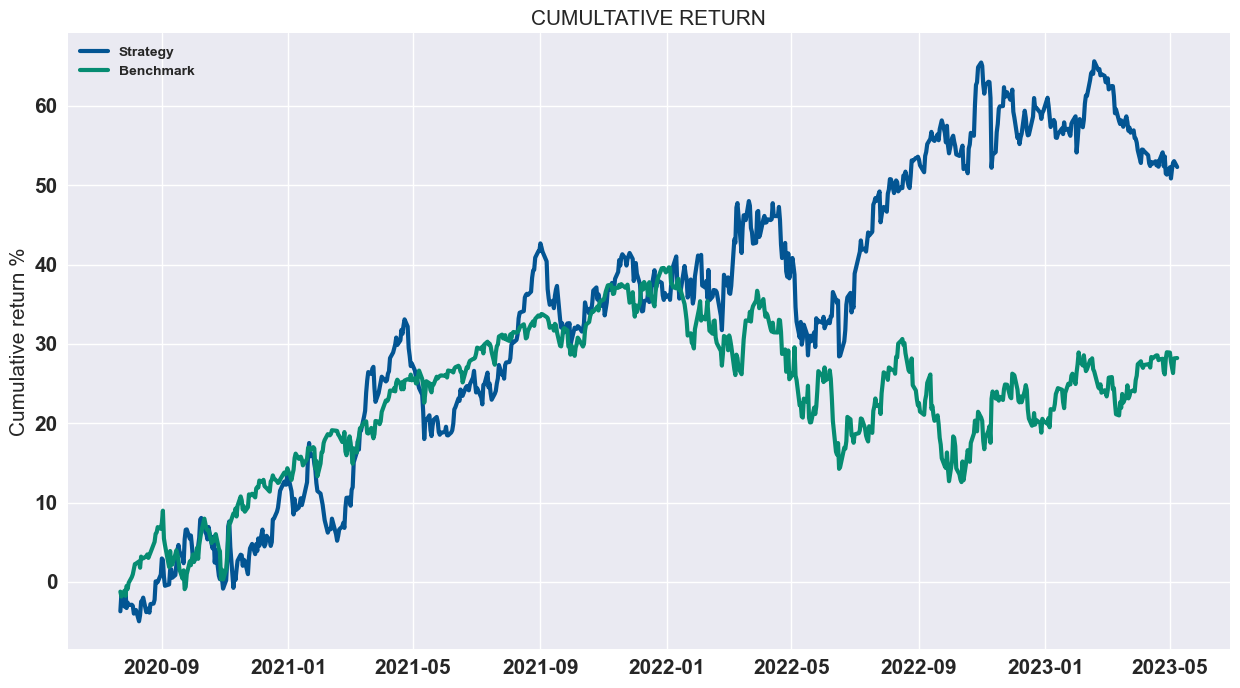

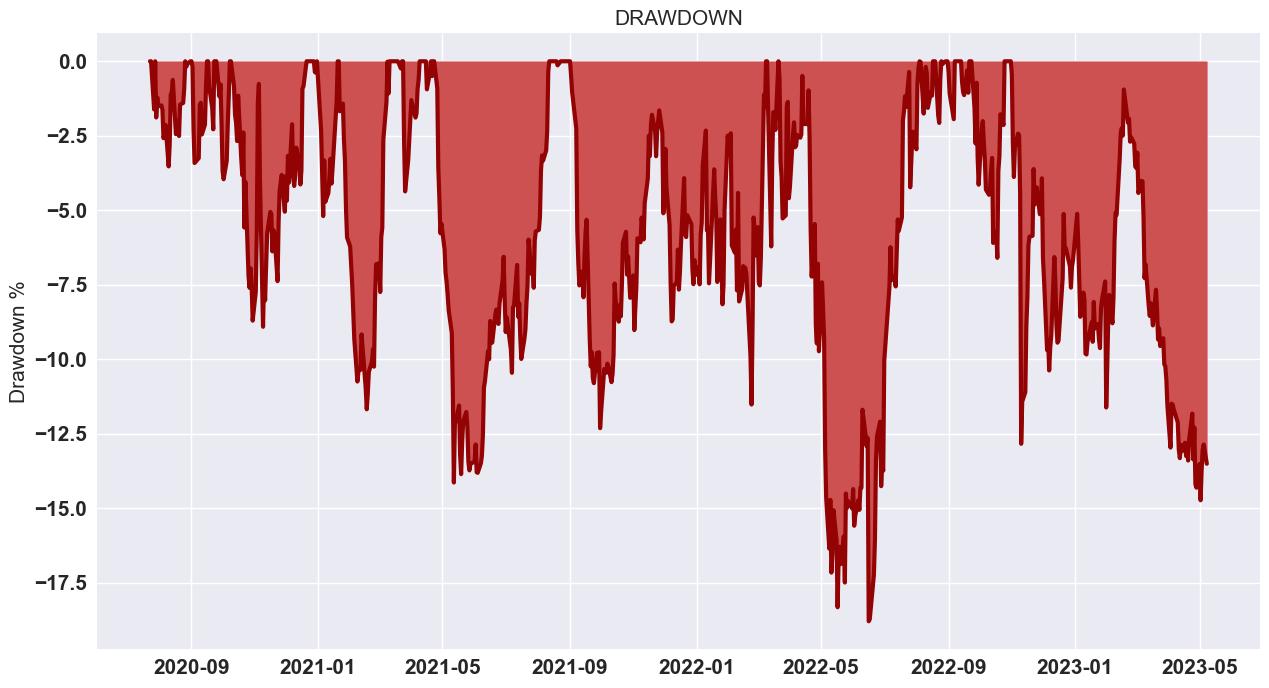

In [253]:
from portfolio import *
# data = res.dropna().loc["2015-01":"2022-12"]
data = res.dropna()
#split = int(0.7*len(data))
data = data.iloc[:split_train,:]
# val = res.dropna().loc["2023-01":]
val = res.dropna().iloc[split_train:,:]

X = optimization_portfolio(MV_criterion, data)

print(np.round(X,3))

spread = 0.00035
low_portfolio = np.multiply(low_assets,np.transpose(X)).sum(axis=1)
high_portfolio = np.multiply(high_assets,np.transpose(X)).sum(axis=1)


# Calcular el retorno acumulado de la cartera (CM)
portfolio_return_test = np.multiply(data,np.transpose(X)).sum(axis=1)
portfolio_return_MV = np.multiply(val,np.transpose(X)).sum(axis=1)

from Backtest import *
import yfinance as yf
backtest_dynamic_portfolio(portfolio_return_MV)

Análisis de las métricas:
- La metrica Beta pone de manifiestola relación entre entre el mercado representado por el indice SP500 y la cartera. Una Beta menor a 1 siginifica que la cartera es menos volatil que le mercado, lo que es bueno porque no tiene un riesgo sistémico significativo.
- La métrica Alpha nos permite entender si una cartera supera o no al indice de referencia. Un Alpha > 0 siginifica que la cartera supera al indice de referencia y esto es bueno. significa que hemos invertido mejor que el indice de referencia.
- El ratio de Sharpe permite entender los beneficios adicionales al asumir un 1% más de riesgo. Una inversión con Sharpe > 1 es una inversión muy buena pues tenemos un rentabilidad esperada positiva, pero con un riesgo asumido menor que el rendimiento. En cambio, 0 < sharpe < 1 sigue siendo una buena inversión porque tenemos un rendimiento esperado positivo pero el riesgo que asumimos es mayor al rendimiento.
- El ratio de Sortino es un indicador que muestra el exceso de rendimiento por encima de un determinado objetivo y, además, por unidad de riesgo solo a la baja. 0 < Sortino < 1 indica que una buena inversión pero no excelente. Tenemos un rendimiento esperado positivo, pero el bajo riesgo que asumimos es mayor que el rendimiento.
- El Drawdown nos da la mayor pérdida de la cartera si entramos en una posición en el peor momento posible, justo antes que la cartera presente su mayor bajada. Un drawdawb del 18.79% siginifica que es la mayor perdida que ha tenido nuestra cartera en su peor moemnto. Cuando pasemos la cartera a producción, si se alcanza esta pérdida pararemos la estrategia de trading automático para recalcular, pues la situación del mercado ha cambiado demasiado y tendremos que reentrenar el modelo.
- Métrica VAR: permite comprender cuanto perderemos diariamente en el peor de los casos con un umbral de error del 5%. En esta cartera encontramos un VAR de 2.3% que significa que el 5% peor de los casos podemos perder un 2.3% diario.
- Métrica cVar: es un derivado del Var pero tiene en cuenta los valores extremos por debajo del Var. En nuestra cartera significa que en el 5% del peor de los casos podemos perder mas del 2.81% diario.

## 3. Encontrar el take profit, stop loss y apalancamientos óptimos

### 3.1. Optimal take profit

Anteriormente hemos calculado la composición óptima de la cartera para reducir el riesgo al máximo. Ahora vamos a pasar a intentar hacer la estrategia más rentable. Para ello buscaremos los umbrales de toma de beneficios (take profit) y limite de pérdidas (stop loss) que maximice aún más el ratio de Sharpe de nuestra cartera.

Lo ideal sería maximizar el ratio de Sharpe teniendo en cuanta ambos parámetros a la vez (take profit y stop loss) pero complica bastante el algoritmo para obtener los retosnos diarios, pues solo con datos diarios no sabemos que extremo se toca antes si el stop loss o el take profit.Para ello necesitaríamos tick data, es decir, un registro de cada moviento del precio de un activo.Sin duda es una idea interesante que proponemos como mejora, pero pos simplicidad hemos decidido maximizar el take profit y el stop loss por separado.

La siguiente función devuelve el ratio de Sharpe para los diferentes umbrales de take profit, para encontrar el punto óptimo de nuestra estrategia.

In [254]:
def find_best_tp(tp):
    tp = tp/100
    
    # Crear la cartera
    pf = pd.concat((low_portfolio, portfolio_return_test,high_portfolio), axis=1).dropna()-spread
    pf.columns = ["low", "Return", "high"]

    # Aplicar el tp
    pf["Return"] = np.where(pf["high"].values>tp, tp, pf["Return"].values)
    pf["Return"] = np.where(pf["Return"].values>tp, tp, pf["Return"].values)
    down = pf["Return"].values
    down = down[down<0]
    
    # Devuelve ratio de Sharpe
    return np.sqrt(252)*pf["Return"].mean()/down.std()

pd.DataFrame([find_best_tp(tp) for tp in np.linspace(0.5,10,30)],  index=np.linspace(0.5,10,30), columns=["Sharpe"])

,Sharpe
0.500000,2.488413
0.827586,3.994081
1.155172,4.599128
1.482759,4.618269
1.810345,4.399662
2.137931,4.355853
2.465517,4.003466
2.793103,3.617858
3.120690,3.204253
3.448276,3.048531


[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.169 	 Alpha: 67.5 %	     Sharpe: 3.041 	 Sortino: 0.24
  -----------------------------------------------------------------------------
    VaR: -1.0 %	 cVaR: -0.51 % 	     VaR/cVaR: 0.506 	 drawdown: 14.53 %
  -----------------------------------------------------------------------------


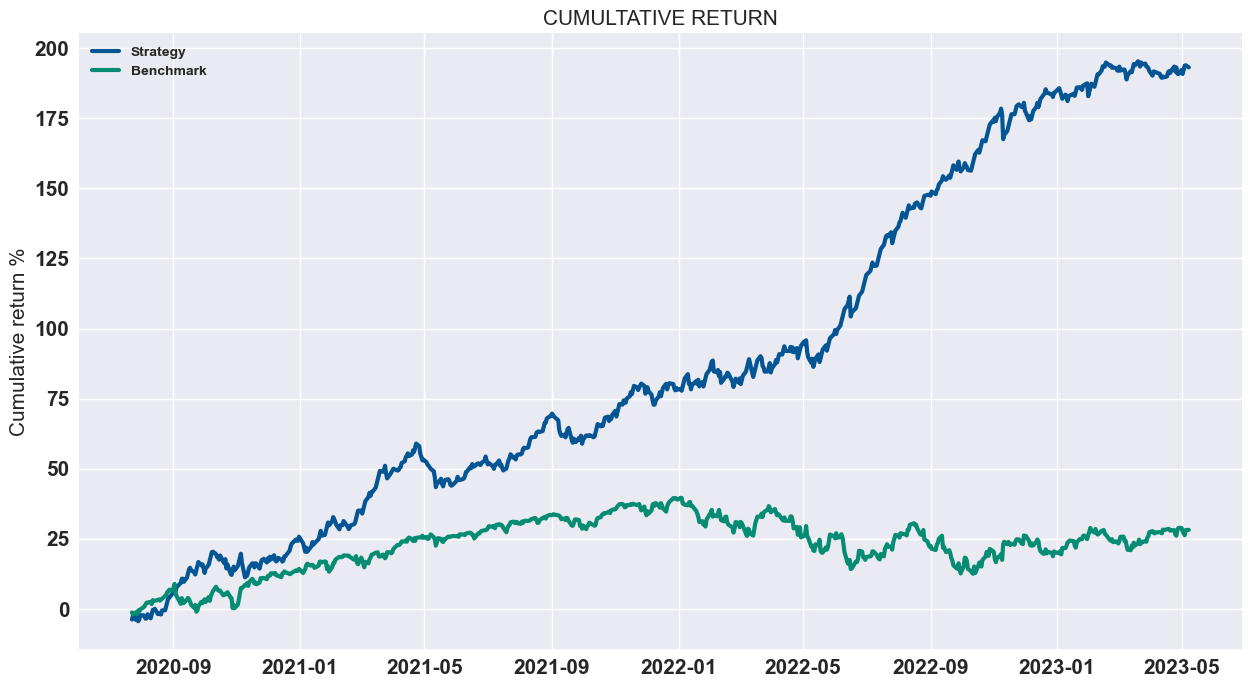

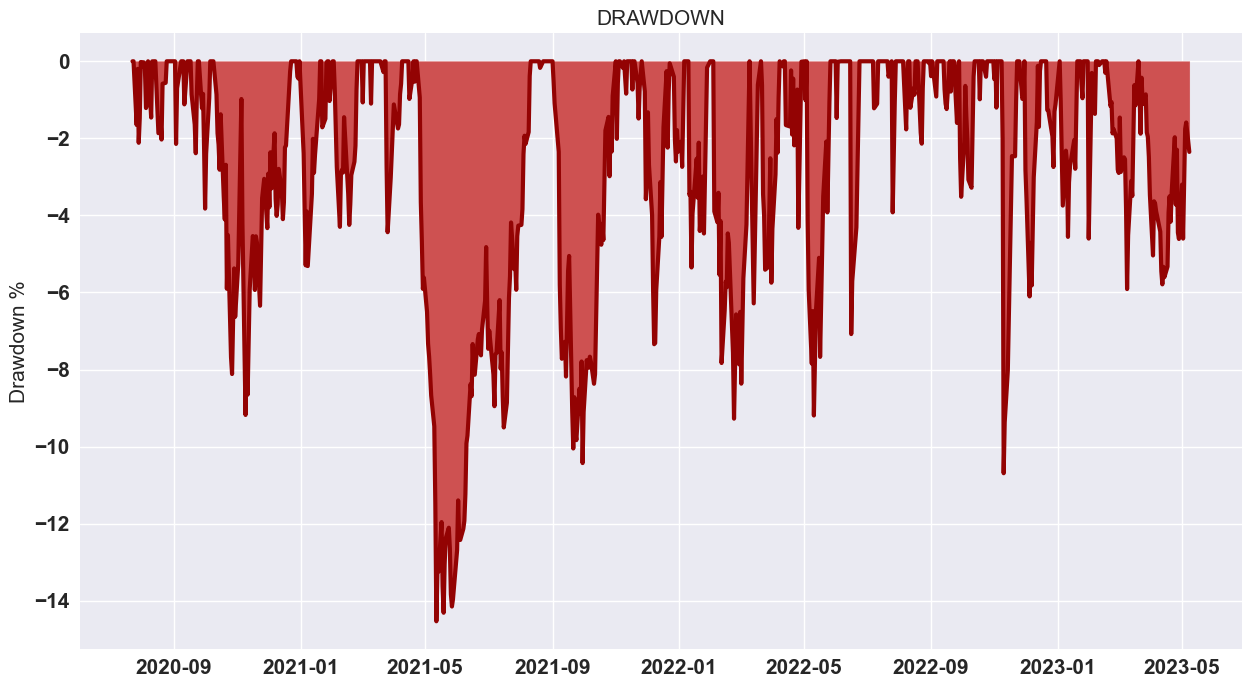

In [255]:
tp = 1.48/100
pf = pd.concat((low_portfolio, portfolio_return_MV,high_portfolio), axis=1).dropna()-spread
pf.columns = ["low", "Return", "high"]

pf["Return"] = np.where(pf["high"].values>tp, tp, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values>tp, tp, pf["Return"].values)

backtest_dynamic_portfolio(pf["Return"])

### 3.2. Optimal stop loss

La siguiente función devuelve el ratio de Sharpe para los diferentes umbrales de stop loss, para encontrar el punto óptimo de nuestra estrategia.

In [256]:
def find_best_sl(sl):
    sl = sl/100
    
    # Crea la cartera
    pf = pd.concat((low_portfolio, portfolio_return_test,high_portfolio), axis=1).dropna()-spread
    pf.columns = ["low", "Return", "high"]

    # aplicar el tp
    pf["Return"] = np.where(pf["low"].values<-sl, -sl, pf["Return"].values)
    pf["Return"] = np.where(pf["Return"].values<-sl, -sl, pf["Return"].values)
    
    # Devuelve ratio de sharpe
    return np.sqrt(252)*pf["Return"].mean()/pf["Return"].std()

pd.DataFrame([find_best_sl(sl) for sl in np.linspace(1,10,30)],  index=np.linspace(1,10,30), columns=["Sharpe"])

,Sharpe
1.000000,-0.637342
1.310345,-0.361217
1.620690,0.351266
1.931034,0.869638
2.241379,1.147394
2.551724,1.365509
2.862069,1.586646
3.172414,1.688830
3.482759,1.712840
3.793103,1.817730


[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.264 	 Alpha: 7.5 %	     Sharpe: 0.43 	 Sortino: 0.037
  -----------------------------------------------------------------------------
    VaR: 2.82 %	 cVaR: 3.31 % 	     VaR/cVaR: 1.175 	 drawdown: 21.65 %
  -----------------------------------------------------------------------------


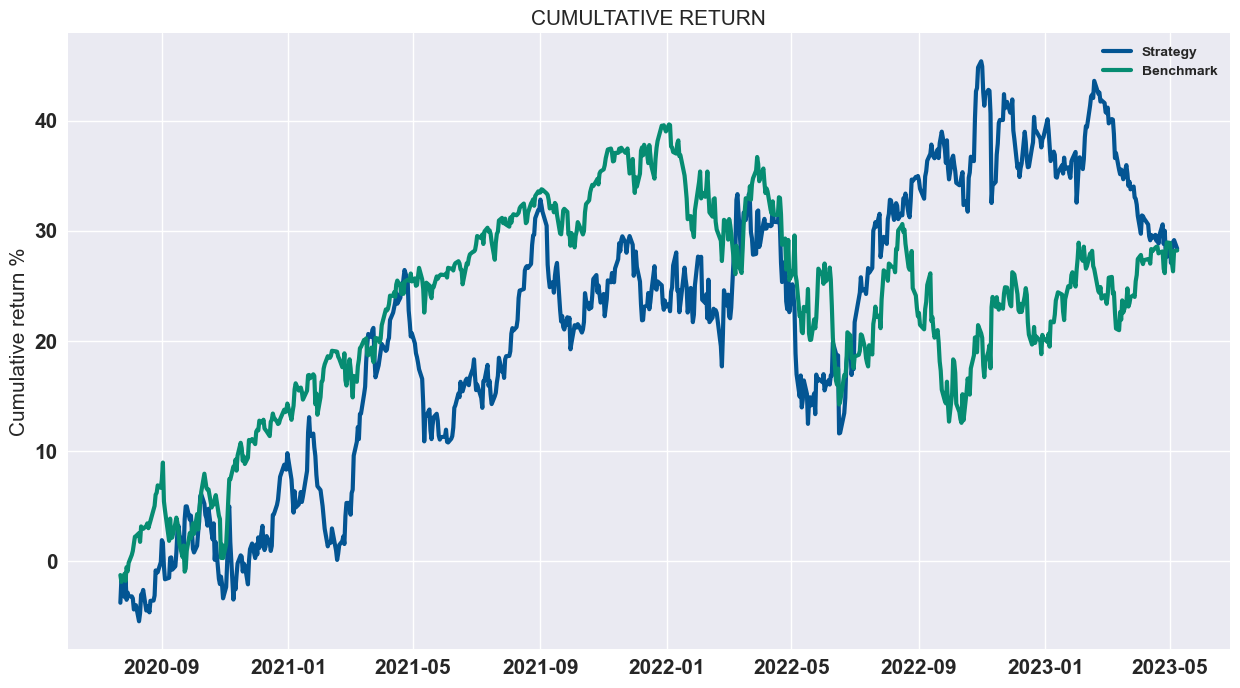

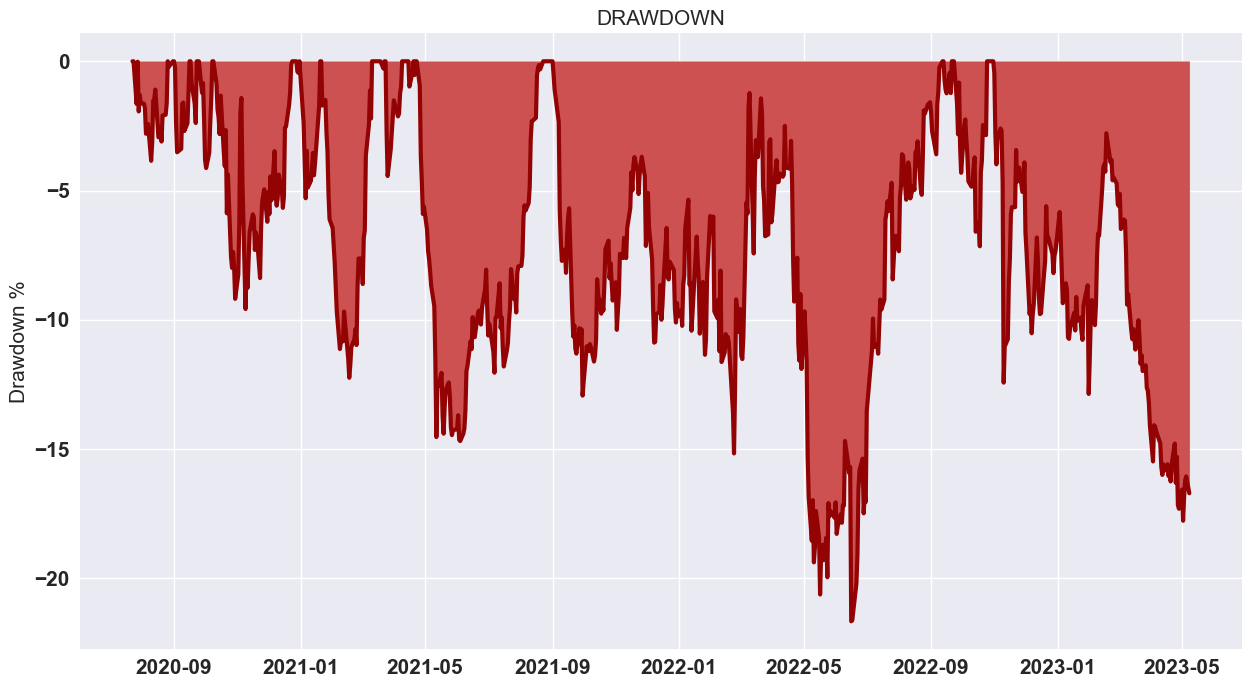

In [264]:
sl = 8.13/100
pf = pd.concat((low_portfolio, portfolio_return_MV,high_portfolio), axis=1).dropna()-spread

pf.columns = ["low", "Return", "high"]
pf["Return"] = np.where(pf["low"].values<-sl, -sl, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values<-sl, -sl, pf["Return"].values)


backtest_dynamic_portfolio(pf["Return"])

### 3.3. Apalancamiento óptimo

El apalancamiento es una herramienta financiera que te facilitan los broker para multiplicar tu capital por un factor de apalacamiento. Es decir, es como invertir con todo tu capital más una parte que te presta el broker. Por ejemplo, si tenemos un capital de 10.000 y un apalancamiento de 1.5 podremos hacer inversiones por valor de 15.000.
El apalancamiento multiplica nuestro poder de inversión y nuestro beneficios. Sim embargo, también multiplica nuestro riesgo de la misma forma.

Dependiendo de nuestro nivel de aversión al riesgo podemos determinar el mejor apalancamiento a utilizar, para su cálculo utilizaremos el método del drawdown. Con este método nosotro fijamos el maximo drawdown (máxima pérdida) que estamos dispuestos a asumir y en función de ello ajustamos el factor de apalancamiento para cumplir con dicho objetivo. Añadir que, estrictamente el concepto de apalancamiento finaciero es para multiplicar nuestro capital x veces pero nosotros vamos a utilizar tambien la función para cuantificar el capital a invertir por debajo de nuestro capital total para así, ajustar la pérdida máxima a nuestra límite de aversión al riesgo. Es decir, si tenemos 10.000 euros quizás solo invirtamos 7.000 si es necesario para cumplir el objetivo de pérdida máxima, por lo que el apalancamiento será de 0.7

apalancamiento óptimo = drawdown maximo a asumir / drawdown de la cartera

Primero calculamos el drawdown de la cartera sin apalancamiento (leverage = 1) y con los stop loss y stop profit óptimos:

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.173 	 Alpha: 67.71 %	     Sharpe: 3.065 	 Sortino: 0.244
  -----------------------------------------------------------------------------
    VaR: -1.07 %	 cVaR: -0.57 % 	     VaR/cVaR: 0.534 	 drawdown: 14.53 %
  -----------------------------------------------------------------------------


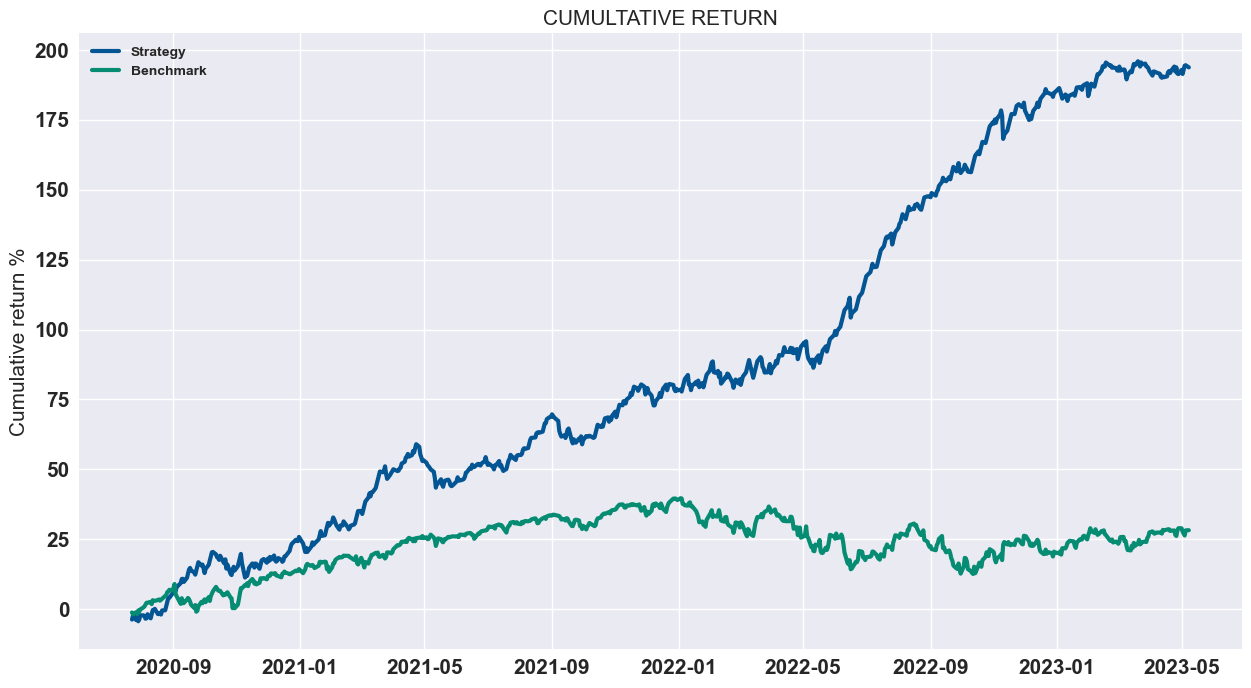

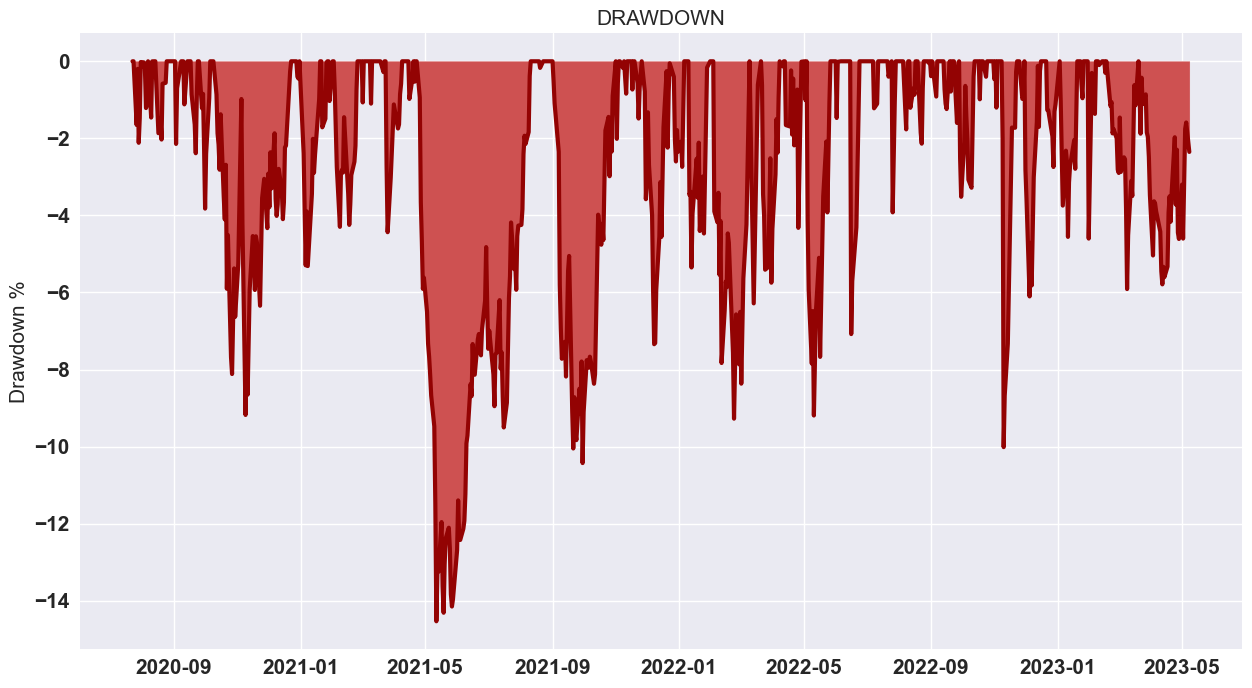

In [265]:
leverage = 1
tp = 1.48/100
sl = 8.13/100
pf = (pd.concat((low_portfolio, portfolio_return_MV,high_portfolio), axis=1).dropna()-spread)*leverage
pf.columns = ["low", "Return", "high"]

pf["Return"] = np.where(pf["high"].values>tp, tp, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values>tp, tp, pf["Return"].values)
pf["Return"] = np.where(pf["low"].values<-sl, -sl, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values<-sl, -sl, pf["Return"].values)

# Graficar el CM
backtest_dynamic_portfolio(pf["Return"])

Observamos que nuestra estrategia tiene un drawdown del 14.53 %. Ahora asumaos dos casos:
- A) soy una persona con mucha aversión al riesgo y la pérdida máxima que quiero asumir es del 10%
- B) soy una persona que está dispuesta asumir un mayor riesgo si ello también significa la posibilidad de obtener una mayor ganancia, por lo que mi pérdida máxima que estoy dispuesto a asumir es del 30 %.

Caso A

In [231]:
print("apalancamiento: ", 10/14.53)

apalancamiento:  0.6882312456985548


[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.121 	 Alpha: 44.71 %	     Sharpe: 2.857 	 Sortino: 0.237
  -----------------------------------------------------------------------------
    VaR: -0.56 %	 cVaR: -0.21 % 	     VaR/cVaR: 0.371 	 drawdown: 10.1 %
  -----------------------------------------------------------------------------


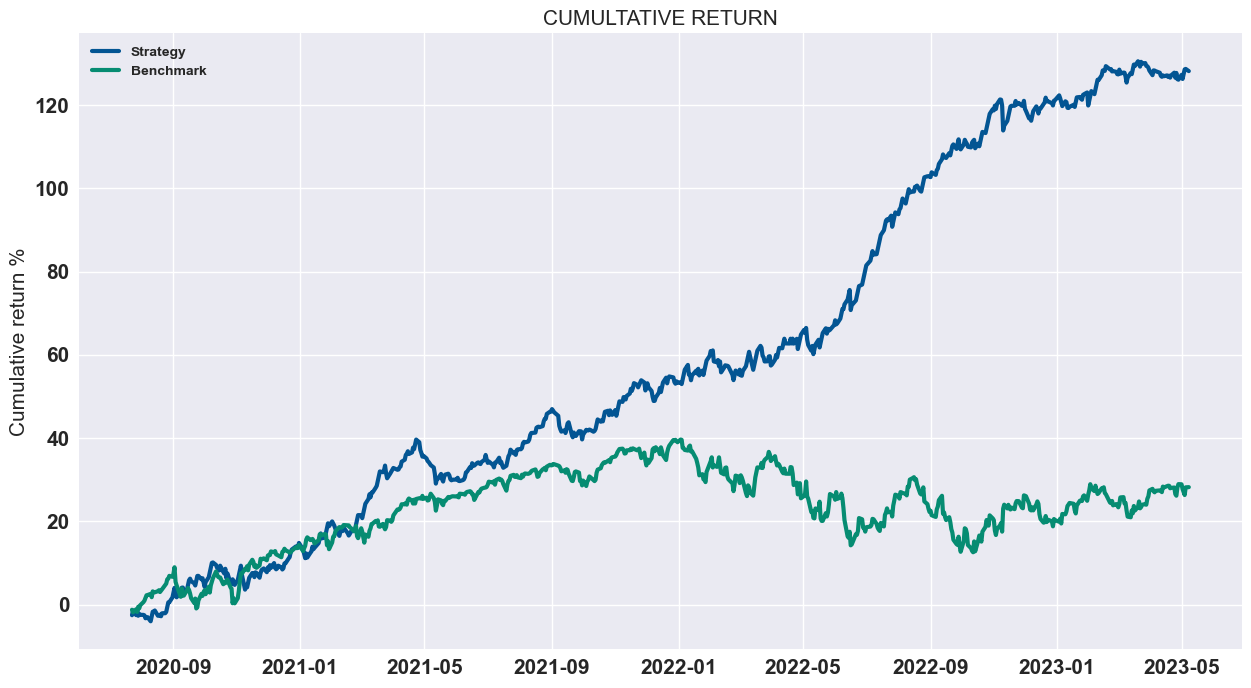

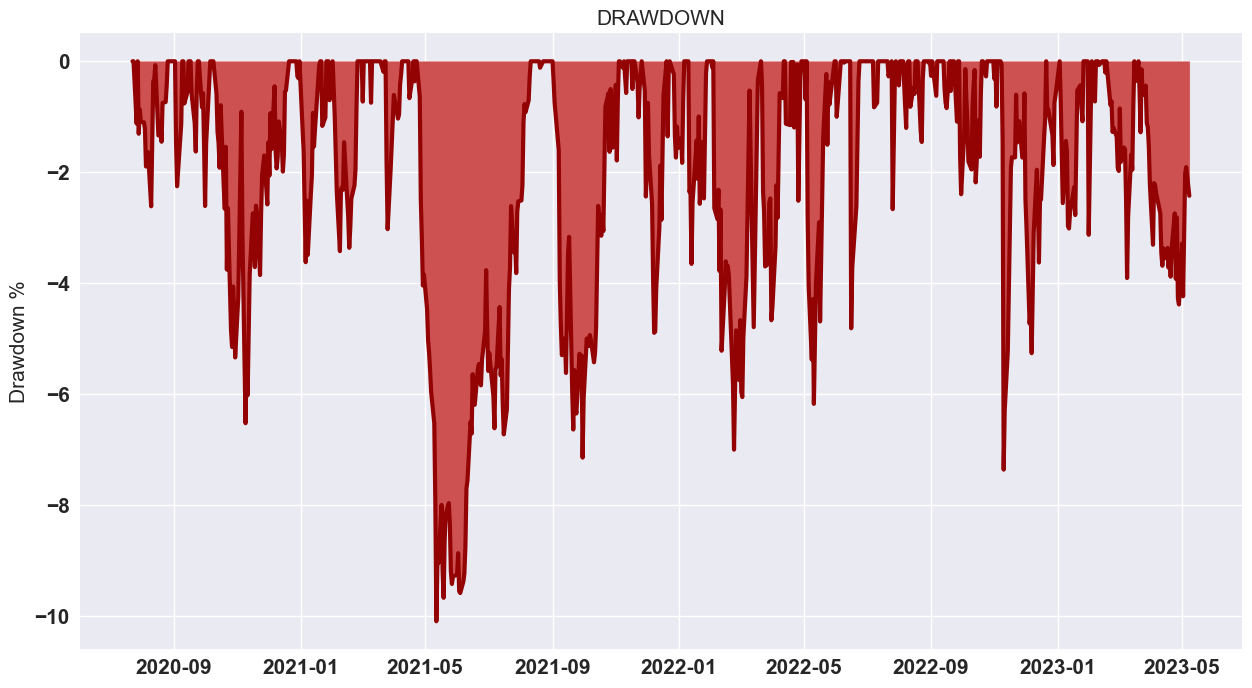

In [249]:
leverage = 0.68
tp = 1.15/100
sl = 7.82
pf = (pd.concat((low_portfolio, portfolio_return_MV,high_portfolio), axis=1).dropna()-spread)*leverage
pf.columns = ["low", "Return", "high"]

pf["Return"] = np.where(pf["high"].values>tp, tp, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values>tp, tp, pf["Return"].values)
pf["Return"] = np.where(pf["low"].values<-sl, -sl, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values<-sl, -sl, pf["Return"].values)

# Graficar el CM
backtest_dynamic_portfolio(pf["Return"])

Observamos como la pérdida máxima de la estrategia es mur próxima al objetivo del 10 % a costa de obtener unos menores beneficios acumulados.

CASO B:

In [268]:
print("apalancamiento: ", 25/14.53)

apalancamiento:  1.720578114246387


[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.14 	 Alpha: 110.13 %	     Sharpe: 3.438 	 Sortino: 0.211
  -----------------------------------------------------------------------------
    VaR: -2.26 %	 cVaR: -1.56 % 	     VaR/cVaR: 0.693 	 drawdown: 22.84 %
  -----------------------------------------------------------------------------


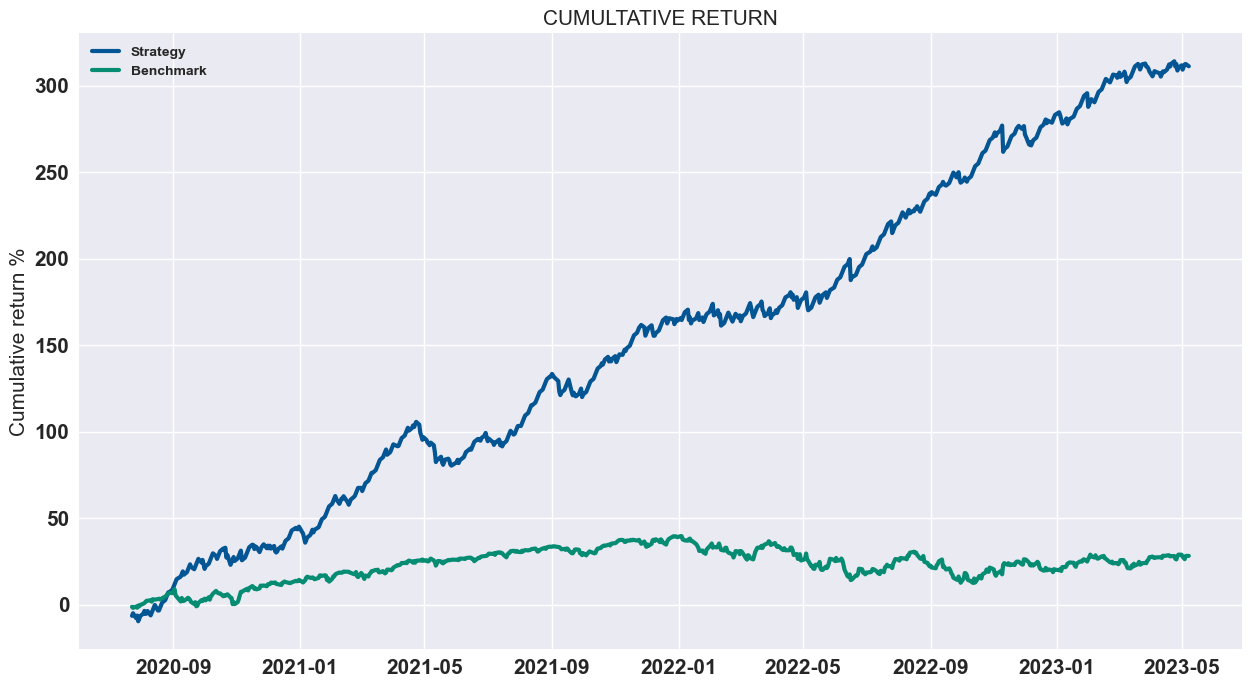

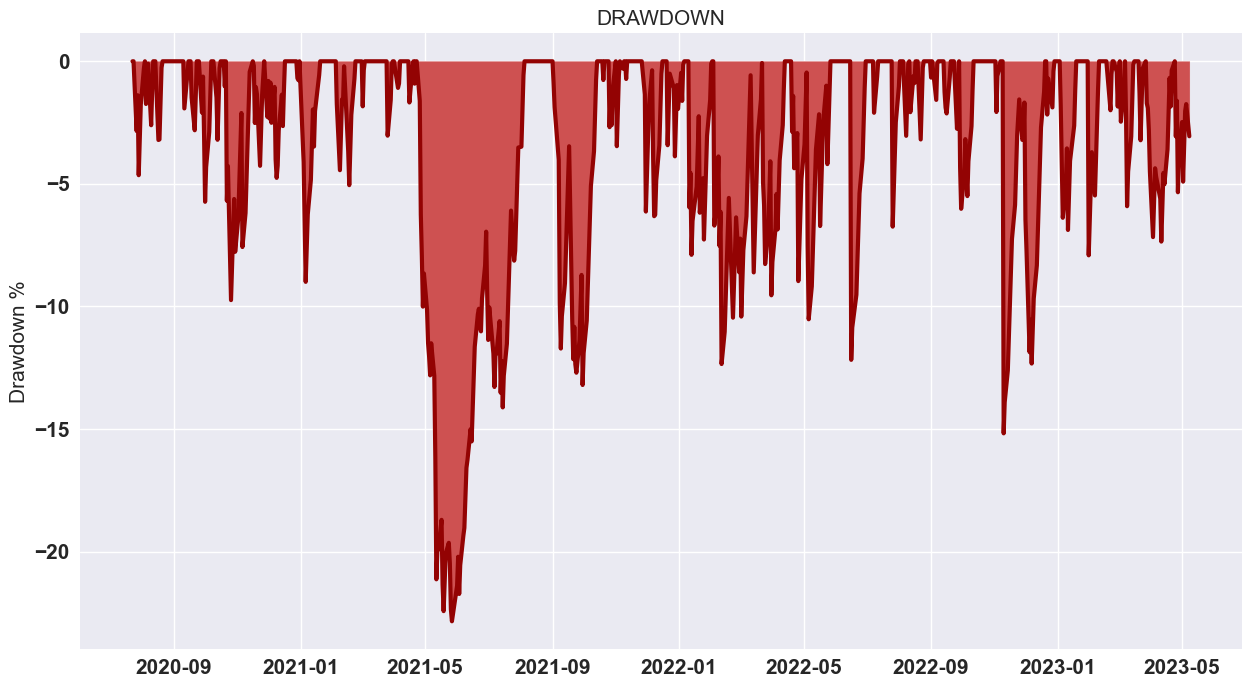

In [269]:
leverage = 1.72
tp = 1.5/100
sl = 9
pf = (pd.concat((low_portfolio, portfolio_return_MV,high_portfolio), axis=1).dropna()-spread)*leverage
pf.columns = ["low", "Return", "high"]

pf["Return"] = np.where(pf["high"].values>tp, tp, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values>tp, tp, pf["Return"].values)
pf["Return"] = np.where(pf["low"].values<-sl, -sl, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values<-sl, -sl, pf["Return"].values)

# Graficar el CM
backtest_dynamic_portfolio(pf["Return"])

Observamos como la máxima pérdida de la estrategia llega a un 22.84% del capital, pero en el largo plazo obtiene unos beneficios muy superiores.

Como conclusión, podemos decir que el apalancamiento óptimo es una muy buena herramienta que permite personalizar la estrategia para cada inversor para obtener bien beneficios más estables en el tiempo o obtener unos beneficios potencialmente mayores pero asumiendo mucho mas riesgo y con grandes varaciones del capital durante la vida de la inversión.